In [1]:
import numpy as np
from sim_handling import Simulation,loadSim, continue_from_surface #uses ds7, both PDEs leads to stable solution
from diffusionstuff7 import f0d,f1d,f2d, getsigmastep_2d
from matplotlib.ticker import FormatStrFormatter
import matplotlib.pyplot as plt

C:\Users\Max-PC\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\llvmlite\llvmpy\__init__.py:3: UserWarning: The module `llvmlite.llvmpy` is deprecated and will be removed in the future.
  warnings.warn(
C:\Users\Max-PC\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\llvmlite\llvmpy\core.py:8: UserWarning: The module `llvmlite.llvmpy.core` is deprecated and will be removed in the future. Equivalent functionality is provided by `llvmlite.ir`.
  warnings.warn(
C:\Users\Max-PC\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\llvmlite\llvmpy\passes.py:17: UserWarning: The module `llvmlite.llvmpy.passes` is deprecated and will be removed in the future. If you are using this code, it should be inlined into your own project.
  warnings.warn(


In [2]:
%matplotlib widget

In [3]:
# Parameters
l = 25
npts = 250#500
midpt = np.round(npts/2).astype(int); print(midpt)
x = np.linspace(-l,l,npts)
N_l = 11
k = N_l/l**2
n = 2
eps = -0.2#05

125


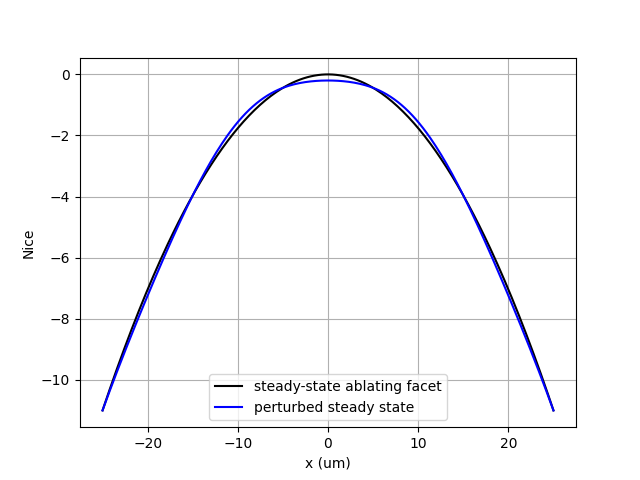

In [4]:
#Perturbation and plot of perturbed estimatd steady state
f_ss = -k*x**2 # Estimated steady state
f_perturbation = eps*np.cos((n+.5)*np.pi*x/l) # Perturbation
f_perturbed = f_ss + f_perturbation
plt.figure()
plt.plot(x,f_ss,'k',label='steady-state ablating facet')
# plt.plot(x,f_perturbation,'r',label='perturbation')
plt.plot(x,f_perturbed,'b',label='perturbed steady state')
plt.grid(True)
plt.xlabel('x (um)')
plt.ylabel('Nice')
plt.legend()

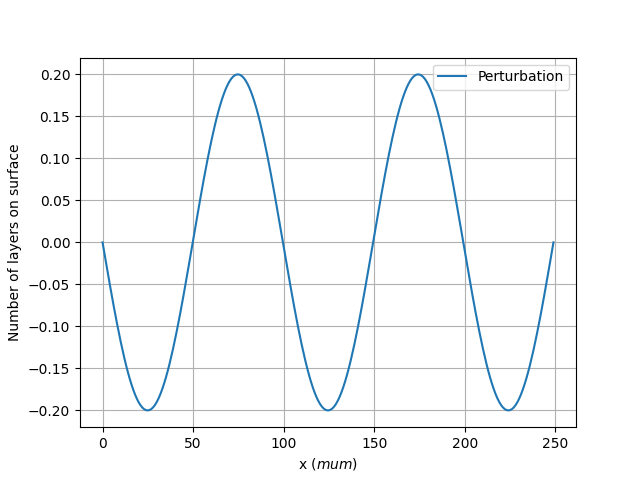

In [5]:
#Perturbation on its own

figname = 'perturbation'
plt.figure(figname)
ax = plt.subplot(111)

ax.set_xlabel(r'x ($mu m$)')
ax.set_ylabel('Number of layers on surface')
ax.plot(f_perturbation, label='Perturbation')
# f_perturbed = ss_1d.results()['y'][-1][1] + f_perturbation
# ax.plot(f_perturbed, label='Perturbed Ice+QLL')
ax.legend()

plt.grid()
plt.show()

In [6]:
plt.close(figname)

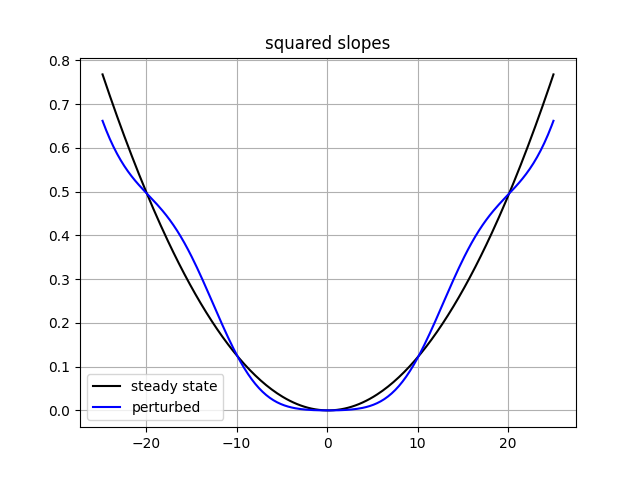

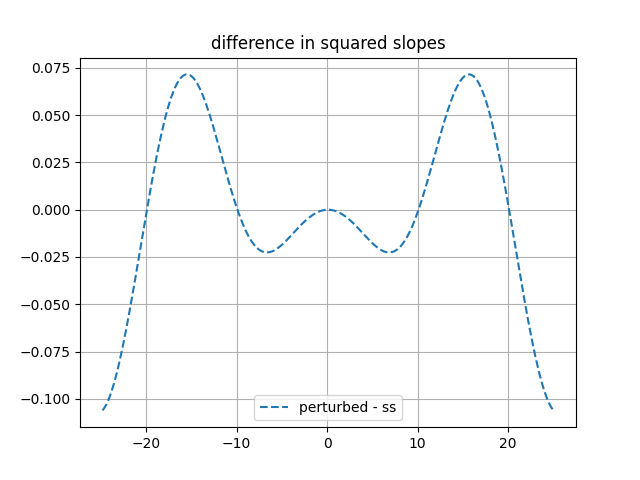

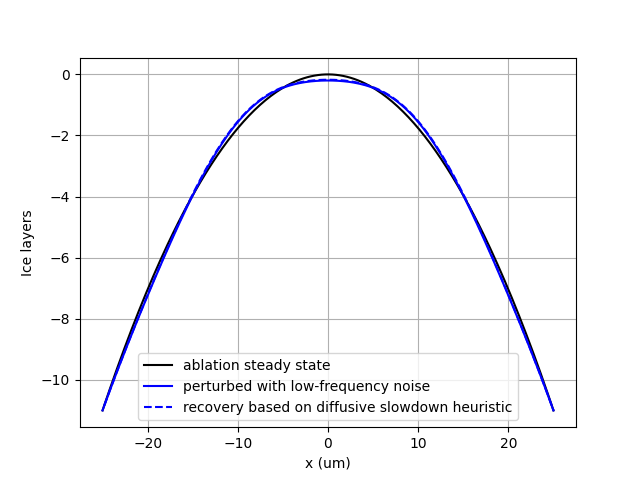

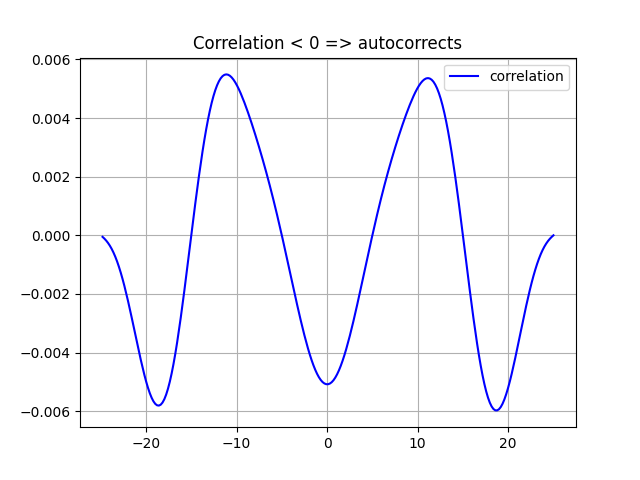

In [7]:
xp = x[1:]

slope_ss_squared = (np.diff(f_ss)/np.diff(x))**2
slope_perturbed_squared = (np.diff(f_perturbed)/np.diff(x))**2
plt.figure()
plt.plot(xp,slope_ss_squared,'k',label='steady state')
plt.plot(xp,slope_perturbed_squared,'b',label='perturbed')
plt.grid(True)
plt.legend()
plt.title('squared slopes')

f2_deviation = slope_perturbed_squared - slope_ss_squared
plt.figure()
plt.plot(xp,f2_deviation,'--',label='perturbed - ss')
plt.grid(True)
plt.legend()
plt.title('difference in squared slopes')

growth_factor = .2
correction = growth_factor*f2_deviation 
f_perturbed_later = f_perturbed[1:] + correction
shift = np.mean(f_ss[1:]-f_perturbed_later)
f_perturbed_later += shift
plt.figure()
plt.plot(x,f_ss,'k',label='ablation steady state')
plt.plot(x,f_perturbed,'b',label='perturbed with low-frequency noise')
plt.plot(xp,f_perturbed_later,'b--',label='recovery based on diffusive slowdown heuristic')
plt.grid(True)
plt.xlabel('x (um)')
plt.ylabel('Ice layers')
plt.legend()

plt.figure()
real_correction = f_perturbed_later - f_perturbed[1:]
plt.plot(xp,f_perturbation[1:]*real_correction,'b',label='correlation')
plt.grid(True)
plt.title('Correlation < 0 => autocorrects')
plt.legend()

In [8]:
#run a 1d sim to get and save the steady state
ss_1d = Simulation(f1d, (250,), method='RK45')
ss_1d.sigmastepmax= 0.20
ss_1d.layermax = 1000

In [9]:
plt.close(0)

breaking because reached max number of layers grown


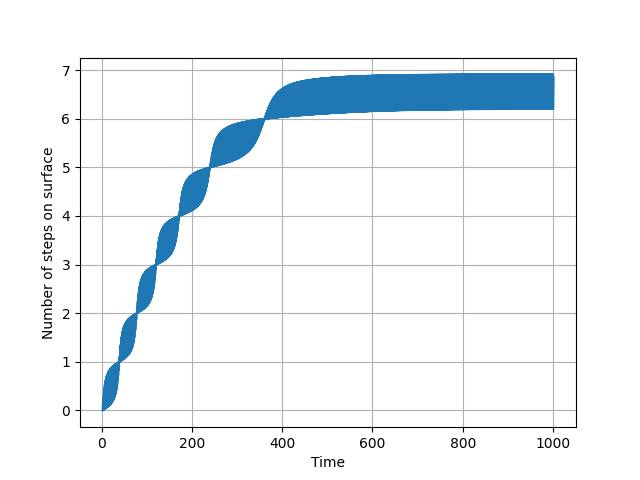

In [10]:
#graph number of steps over time
Ntot = ss_1d.getNtot()
#Ntot = np.load(filename, mmap_mode='r')[:,1,:,:]# if loading resutls from file
Nss_v_time = np.ptp(Ntot, axis=1)

fignum = 0
plt.figure(fignum)
ax = plt.subplot(111)

#ax.plot(test_f2d_sim.results()['t'],maxes-mins)
ax.plot(Ntot[:,0],Nss_v_time)
ax.set_ylabel('Number of steps on surface')
ax.set_xlabel('Time')
plt.grid()
plt.show()

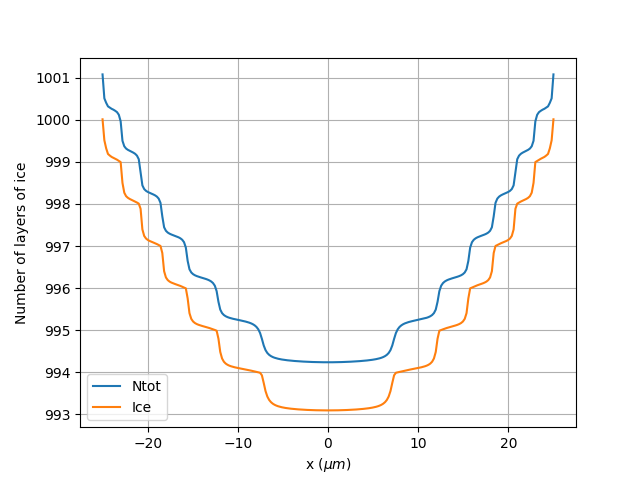

In [11]:
# plot ending surface
Ntot = ss_1d.getNtot()[-1]
Nice = ss_1d.getNice()[-1]

plt.figure()
plt.plot(x, Ntot, label='Ntot')
plt.plot(x, Nice, label='Ice')
plt.xlabel(r'x ($\mu m$)')
plt.ylabel('Number of layers of ice')
plt.grid()
plt.legend()
plt.show()


In [12]:
#save the steady state, used as starting point for perturbed simulations
steady_state_ntot = ss_1d.results()['y'][-1][1]
np.save('steady_state_ntot_1000.npy',np.asarray(steady_state_ntot))

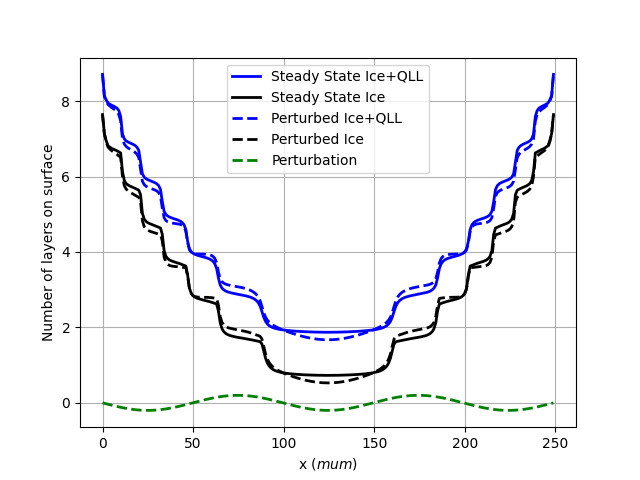

In [13]:
#add the perturbation to the ending surface
ending_fliq,ending_ntot = ss_1d.results()['y'][-1]
fignum = 'perturbation of steady state'
plt.close(fignum)
plt.figure(fignum)
ax = plt.subplot(111)
#ax.plot(test_f2d_sim.results()['t'],maxes-mins)


ax.set_xlabel(r'x ($mu m$)')
ax.set_ylabel('Number of layers on surface')

ntot_perturbed = ss_1d.results()['y'][-1][1] + f_perturbation
fliq_perturbed = ss_1d.results()['y'][-1][0]

offset = np.mean(ntot_perturbed)-4

ax.plot(ending_ntot-offset, label='Steady State Ice+QLL', color='b', linewidth=2)
ax.plot(ending_ntot-ending_fliq-offset, label='Steady State Ice', color='k', linewidth=2)
ax.plot(ntot_perturbed-offset, color='b', label='Perturbed Ice+QLL',linestyle='--', linewidth=2)
ax.plot(ntot_perturbed-fliq_perturbed-offset, color='k', label='Perturbed Ice', linestyle='--', linewidth=2)
ax.plot(f_perturbation, color='g', label='Perturbation', linestyle='--', linewidth=2)
ax.legend()

plt.grid()
plt.show()

In [14]:
plt.close(fignum)

In [15]:
#run the simulation with the heuristic
#heuristic_1d = Simulation(f1d, (500,), method='RK45')
heuristic_1d = continue_from_surface(ss_1d, ss_1d.results()['y'][-1]+f_perturbation) #copies sim settings and begins from ending surface
heuristic_1d.layermax = 250
heuristic_ntot = heuristic_1d.getNtot()
heuristic_ice = heuristic_1d.getNice()

breaking because reached max number of layers grown


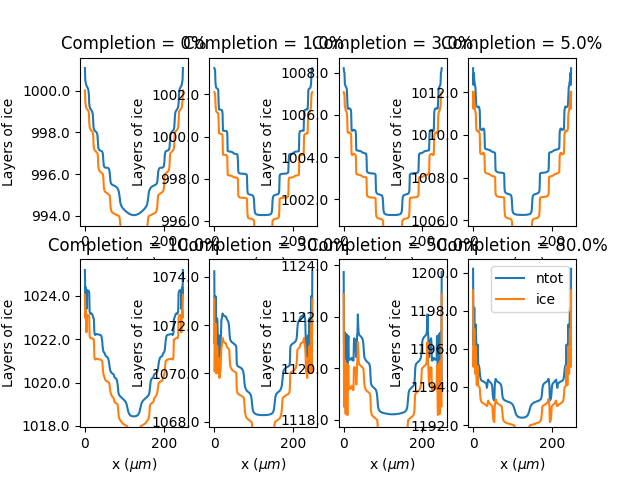

In [16]:
#plot the surface over time on subplots

#run the simulation
fig, axs = plt.subplots(2, 4)
for i, cmpltion in enumerate([0,0.01,0.03,0.05,0.1,0.3,0.5,0.8]):
#for i, cmpltion in enumerate([0.1,0.12,0.15, 0.18,0.2,0.23,0.26,0.3]):

    xs = heuristic_ntot[int(cmpltion*heuristic_ntot.shape[0]),:]
    ice = heuristic_ice[int(cmpltion*heuristic_ntot.shape[0]),:]
    axs[i//4, i%4].set_xlabel(r'x ($\mu m$)')
    axs[i//4, i%4].set_ylabel('Layers of ice')
    axs[i//4, i%4].set_ylim(bottom=min(xs)-.5, top=max(xs)+.5)
    axs[i//4, i%4].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    axs[i//4, i%4].set_title('Completion = '+str(cmpltion*100)+'%')
    axs[i//4, i%4].plot(xs, label='ntot')
    axs[i//4, i%4].plot(ice, label='ice')
plt.legend()
plt.show()

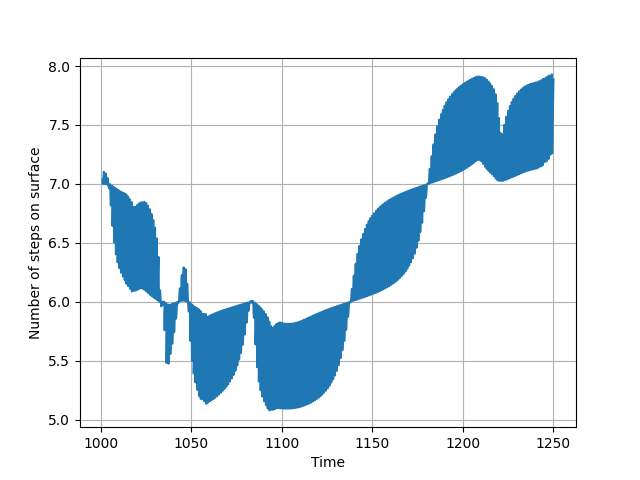

In [17]:
# plot number of steps over time with heuristic
fignum = 'nss over time starting with heuristic'
plt.close(fignum)

#print(maxes,mins)
plt.figure(fignum)
ax = plt.subplot(111)

#ax.plot(test_f2d_sim.results()['t'],maxes-mins)
ax.plot(heuristic_ntot[:,0],np.ptp(heuristic_ntot, axis=1))
ax.set_ylabel('Number of steps on surface')
ax.set_xlabel('Time')
plt.grid()
plt.show()

In [18]:
#run the simulations for subplots, setting params
amplitudes = [-0.05,0,0.05]
frequencies = [0,1,2,3,4]

list_of_param_pairs = []
for amp in amplitudes:
    for freq in frequencies:
        list_of_param_pairs.append((amp,freq))

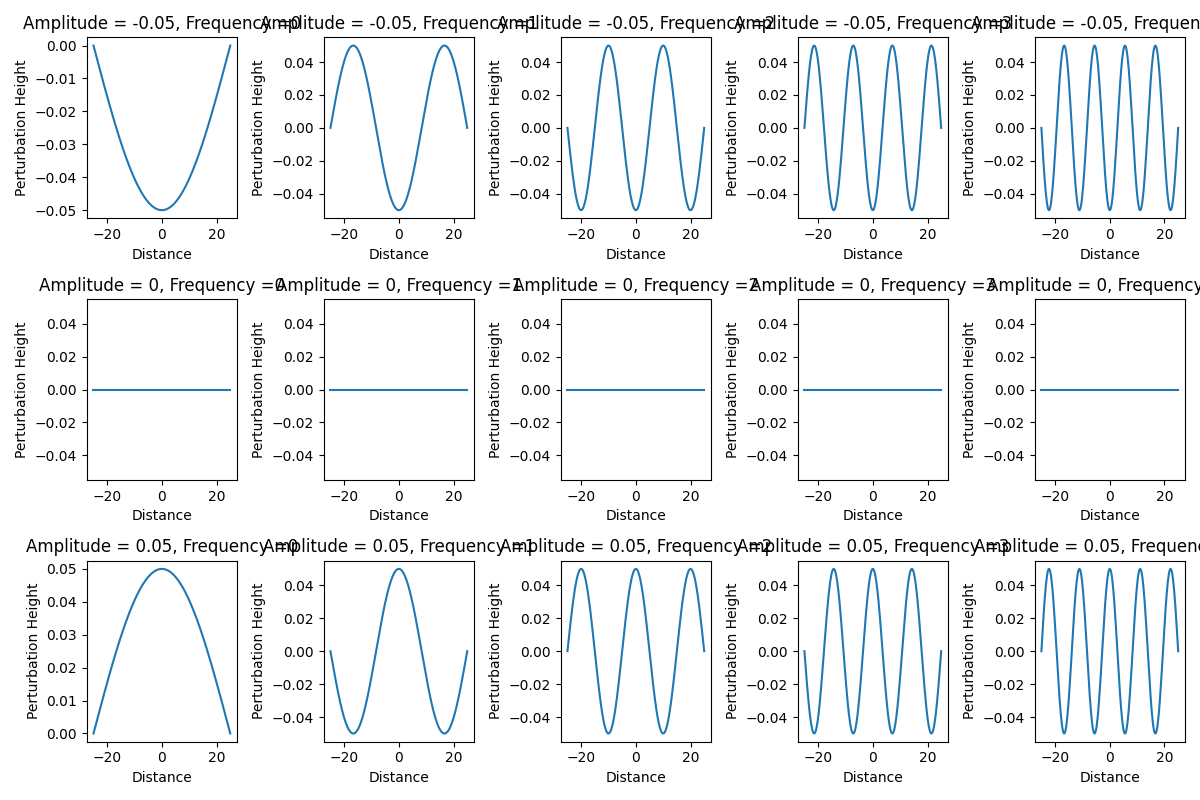

In [19]:
x = np.linspace(-l,l,npts)
xlen, ylen = len(amplitudes), len(frequencies)
fig, axs = plt.subplots(xlen, ylen, figsize=(12, 8))
for i, (amp, freq) in enumerate(list_of_param_pairs):
    # create perturbation
    eps = amp
    n = freq
    this_perturbation = eps * np.cos((n + 0.5) * np.pi * x / l)

    # plot the perturbation
    axs[i // ylen, i % ylen].plot(x, this_perturbation)
    axs[i // ylen, i % ylen].set_title('Amplitude = ' + str(amp) + ', Frequency =' + str(freq))
    axs[i // ylen, i % ylen].set_xlabel('Distance')
    axs[i // ylen, i % ylen].set_ylabel('Perturbation Height')

plt.tight_layout()
plt.show()


In [20]:
#run the sims and collect ending surfaces
last_step_results = []
nss_results = []
for (amp,freq) in list_of_param_pairs:
    #create perturbation
    eps = amp
    n = freq
    this_perturbation = eps*np.cos((n+.5)*np.pi*x/l)

    #copy sim settings and begins from ending surface + perturbation
    heur_sim_perturbed = continue_from_surface(ss_1d, ss_1d.results()['y'][-1]+this_perturbation)

    #double the number of layers to see longer term effects of perturbation
    heur_sim_perturbed.layermax *=2

    #run and append results for each simulation (for plotting later)
    last_step_results.append(heur_sim_perturbed.results()['y'][-1])
    nss_results.append(np.ptp(heur_sim_perturbed.getNtot(), axis=1)) #ptp = max-min

breaking because reached max number of layers grown
breaking because reached max number of layers grown
breaking because reached max number of layers grown
breaking because reached max number of layers grown
breaking because reached max number of layers grown
breaking because reached max number of layers grown
breaking because reached max number of layers grown
breaking because reached max number of layers grown
breaking because reached max number of layers grown
breaking because reached max number of layers grown
breaking because reached max number of layers grown
breaking because reached max number of layers grown
breaking because reached max number of layers grown
breaking because reached max number of layers grown
breaking because reached max number of layers grown


In [21]:
# run simulation and get average surface for 1000 steps 
# (to subtract from the perturbed surfaces (after evolving for some time) to get the perturbation (away) from the steady state)

heur_sim = continue_from_surface(ss_1d, ss_1d.results()['y'][-1])
heur_sim.layermax = 1100
heur_sim.run()

breaking because reached max number of layers grown


In [22]:
# get the average surface over the last 1000
last_thousand_steps = np.asarray(heur_sim.results()['y'][-40000:]) # ntot, fliq (2d array, 2 by n)
last_thousand_steps_ntot, last_thousand_steps_fliq = last_thousand_steps[:,1], last_thousand_steps[:,0]


print(last_thousand_steps.shape)
#before averaging, subtract the # of steps already grown from each timestep
#last_thousand_steps_ntot =  
print(last_thousand_steps_ntot.shape)


just_ntot_surface = [timestep_surface[:] - np.min(timestep_surface) for timestep_surface in last_thousand_steps_ntot]
just_fliq_surface = [timestep_surface[:] - np.min(timestep_surface) for timestep_surface in last_thousand_steps_fliq]

last_unperturbed_thousand_steps_ntot_avg = np.mean(just_ntot_surface, axis=0) # average over the 1000 steps
last_unperturbed_thousand_steps_fliq_avg = np.mean(just_fliq_surface, axis=0) # average over the 1000 steps

last_unperturbed_thousand_steps_ice_avg = last_unperturbed_thousand_steps_ntot_avg - last_unperturbed_thousand_steps_fliq_avg

print(last_unperturbed_thousand_steps_ntot_avg.shape)

(40000, 2, 250)
(40000, 250)
(250,)


In [23]:
plt.close('average surface')

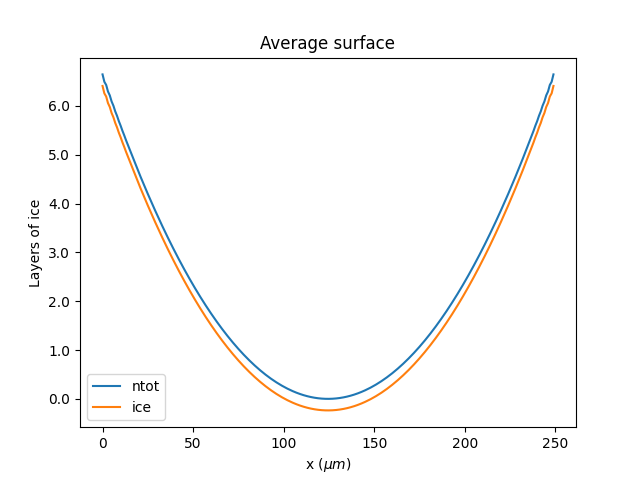

In [24]:
# plot the average surface
plt.close(fignum)
fignum = 'average surface of unperturbed simulation'
plt.figure(fignum)
ax = plt.subplot(111)
ax.set_xlabel(r'x ($\mu m$)')
ax.set_ylabel('Layers of ice')
#ax.set_ylim(bottom=min(last_thousand_steps_ntot_avg)-.5, top=max(last_thousand_steps_ntot_avg)+.5)
ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax.set_title('Average surface')
ax.plot(last_unperturbed_thousand_steps_ntot_avg, label='ntot')
ax.plot(last_unperturbed_thousand_steps_ice_avg, label='ice')
plt.legend()
plt.show()

In [25]:
#save the results
np.save('heuristic_last_step_results.npy', last_step_results)
np.save('heuristic_nss_results.npy', nss_results)

C:\Users\Max-PC\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\lib\npyio.py:518: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


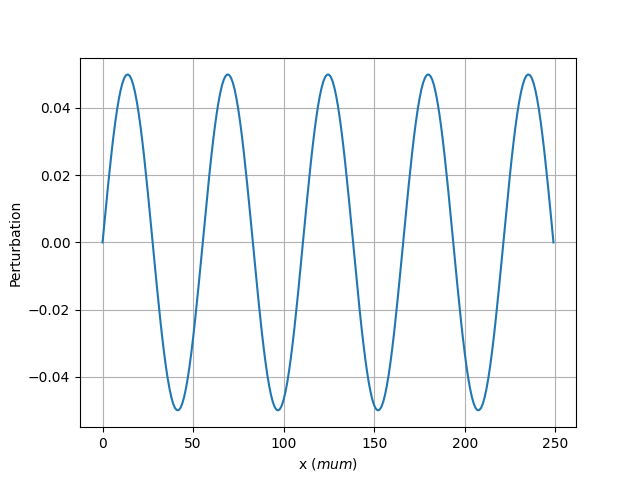

In [26]:
#create the perturbation and plot it
eps = 0.05
n = 4
x = np.linspace(-l,l,npts)

this_perturbation = eps*np.cos((n+.5)*np.pi*x/l)


#plot the perturbation
plt.figure()
ax = plt.subplot(111)
ax.plot(this_perturbation)
ax.set_xlabel(r'x ($mu m$)')
ax.set_ylabel('Perturbation')
plt.grid()

In [27]:
plt.close(fignum)

In [28]:
nss_results = np.load('heuristic_nss_results.npy', allow_pickle=True)

0 0
0 1
0 2
0 3
0 4
1 0
1 1
1 2
1 3
1 4
2 0
2 1
2 2
2 3
2 4


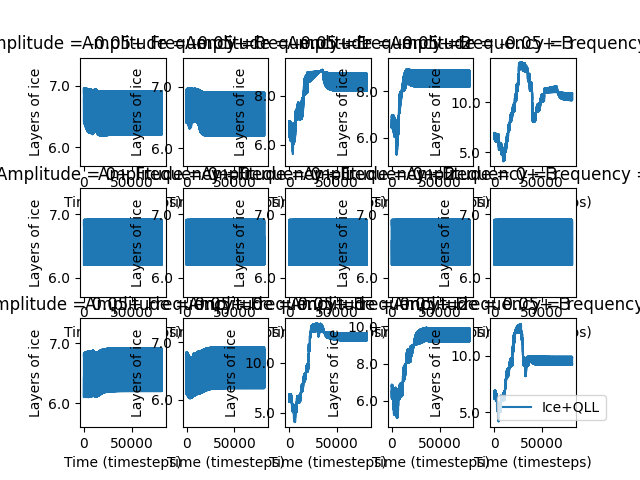

In [29]:
#plot the perturbed surface at the end on subplots

show_ntot=True
show_ice=True

xlen,ylen = len(amplitudes), len(frequencies)
fig, axs = plt.subplots(xlen,ylen)
for i, (amp,freq) in enumerate(list_of_param_pairs):
    #print(i)
    print(i//ylen, i%ylen)
    # ntot = last_step_results[i][1]
    # ice = last_step_results[i][1]-last_step_results[i][0]
    
    axs[i//ylen, i%ylen].set_xlabel('Time (timesteps)')
    axs[i//ylen, i%ylen].set_ylabel('Layers of ice')

    nss = nss_results[i]
    
    axs[i//ylen, i%ylen].set_ylim(bottom=min(nss)-.5, top=max(nss)+.5)
    
    axs[i//ylen, i%ylen].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    axs[i//ylen, i%ylen].set_title('Amplitude = '+str(amp)+'+ Frequency ='+str(freq))

    if show_ntot: axs[i//ylen, i%ylen].plot(nss, label='Ice+QLL')

plt.legend()
plt.show()

In [ ]:
print(i//xlen, i%ylen)
print(axs.shape)

In [ ]:
#get average surfaces for 1000 steps of the new stable surface for a perturbed simulation

#run the simulation
heur_sim_perturbed = continue_from_surface(ss_1d, last_step_results[4]) #frequency = 4 negative amplitude
heur_sim_perturbed.layermax = 1100
heur_sim_perturbed.run()

# get the average surface over the last 1000
last_thousand_steps = np.asarray(heur_sim_perturbed.results()['y'][-40000:]) # ntot, fliq (2d array, 2 by n)
last_thousand_steps_ntot, last_thousand_steps_fliq = last_thousand_steps[:,1], last_thousand_steps[:,0]

#before averaging, subtract the # of steps already grown from each timestep
just_ntot_surface = [timestep[:] - np.min(timestep) for timestep in last_thousand_steps_ntot]
just_fliq_surface = [timestep[:] - np.min(timestep) for timestep in last_thousand_steps_fliq]

# average over the 1000 steps
last_thousand_steps_ntot_avg = np.mean(just_ntot_surface, axis=0) 
last_thousand_steps_fliq_avg = np.mean(just_fliq_surface, axis=0) 

avg_perturbed_ntot = last_thousand_steps_ntot_avg
avg_perturbed_ice = last_thousand_steps_ntot_avg-last_thousand_steps_fliq_avg

# plot the average surface
fignum = 'average surface of the perturbed simulation'
plt.close(fignum)
plt.figure(fignum)
ax = plt.subplot(111)
ax.set_xlabel(r'x ($\mu m$)')
ax.set_ylabel('Layers of ice')
ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax.set_title('Average surface')
ax.plot(avg_perturbed_ntot, label='ntot')
ax.plot(avg_perturbed_ice, label='ice')
plt.legend()
plt.show()

In [ ]:
#plot the ending surface for the various simulations on subplots

xlen,ylen =len(amplitudes), len(frequencies)
fig, axs = plt.subplots(xlen,ylen)
for i, (amp,freq) in enumerate(list_of_param_pairs):
    
    ntot = last_step_results[i][1]
    ice = last_step_results[i][1]-last_step_results[i][0]
    
    axs[i//ylen, i%ylen].set_xlabel(r'x ($\mu m$)')
    axs[i//ylen, i%ylen].set_ylabel('Layers of ice')
    axs[i//ylen, i%ylen].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    
    axs[i//ylen, i%ylen].set_title('Amplitude = '+str(amp)+'+ Frequency ='+str(freq))

    if show_ntot: axs[i//ylen, i%ylen].plot(ntot, label='Ice+QLL')
    if show_ice: axs[i//ylen, i%ylen].plot(ice, label='Ice')

plt.legend()
plt.show()

In [ ]:
#plot the derivative of the last Nss over time on subplots
plt.close('d/dx of ending surface')
plt.figure('d/dx of ending surface')
ax = plt.subplot(111)


last_step_results = np.asarray(last_step_results)
print(last_step_results.shape)
print(last_step_results[i][1].shape)


# #before calculating the derivative, subtract the # of steps already grown from each timestep
# just_ntot_surface = last_step_results[i][1] - np.min(last_step_results[i][1]) 
# just_ice_surface = (last_step_results[i][1]-last_step_results[i][0]) - np.min(last_step_results[i][1]-last_step_results[i][0])
# #just_ice_surface = [timestep[:] - np.min(timestep) for timestep in last_step_results[i][1]-last_step_results[i][0]]

#also subtract the average steady state (unperturbed) surface
just_ntot_surface = avg_perturbed_ntot - last_unperturbed_thousand_steps_ntot_avg
just_ice_surface = avg_perturbed_ice - last_unperturbed_thousand_steps_ice_avg

#just_ntot_surface = [x[:] - last_thousand_steps_ntot_avg for x in just_ntot_surface]
#just_ice_surface = [x[:] - last_thousand_steps_ice_avg for x in just_ice_surface]

i = 14

#ntot = last_step_results[i][1]
#ice = last_step_results[i][1]-last_step_results[i][0]
ntot = just_ntot_surface
ice = just_ice_surface

#plot the demeaned surfaces
ax.plot(ntot, label='Ice+QLL')
#ax.plot(ice, label='Ice')

#calculate dntot_dx using numpy gradient - more accurate for large dx
dntot_dx = np.gradient(ntot, x[1]-x[0])

dice_dx = np.gradient(ice, x[1]-x[0])

ax.set_xlabel(r'x ($\mu m$)')
ax.set_ylabel('Layers of ice')
ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))

ax.set_title('Amplitude = '+str(amp)+'+ Frequency ='+str(freq))

if show_ntot: ax.plot(dntot_dx, label='d/dx of Ice+QLL')
#if show_ice: ax.plot(dice_dx, label='Ice')

plt.legend()
plt.show()

In [ ]:
# plot the derivative and other subplots on the same figure
#plt.close('d/dx of ending surface')
fig, axs = plt.subplots(2, 2, figsize=(10, 8))

# plot the derivative of the last Nss over time

# define the x array with the same length as ntot
x = np.linspace(0, (ntot.shape[0]-1)*(x[1]-x[0]), ntot.shape[0])

axs[0, 0].set_xlabel(r'x ($\mu m$)')
axs[0, 0].set_ylabel('Layers of ice')
axs[0, 0].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
axs[0, 0].set_title('Derivative of ending surface')

axs[0, 0].plot(dntot_dx, label='Ice+QLL')
axs[0, 0].plot(dice_dx, label='Ice')

axs[0, 0].legend()

# plot the derivative square (Z^2) vs distance

# Z_squared_ntot = dntot_dx**2
# Z_squared_ice = dice_dx**2
log_offset = 1e-8
Z_squared_ntot = (dntot_dx + log_offset)**2
Z_squared_ice = (dice_dx + log_offset)**2


axs[0, 1].set_xlabel(r'x ($\mu m$)')
axs[0, 1].set_ylabel(r'$Z^2$')
axs[0, 1].set_title('Derivative square (Z^2) vs distance')

axs[0, 1].plot(x, Z_squared_ntot, label='Ice+QLL')
axs[0, 1].plot(x, Z_squared_ice, label='Ice')

axs[0, 1].legend()

# plot the histogram of Z^2
hist_ntot, bin_edges_ntot = np.histogram(Z_squared_ntot, bins=50, density=True)
hist_ice, bin_edges_ice = np.histogram(Z_squared_ice, bins=50, density=True)
axs[1, 0].bar(bin_edges_ntot[:-1], hist_ntot, width=0.05, label='Ice+QLL')
axs[1, 0].bar(bin_edges_ice[:-1], hist_ice, width=0.05, alpha=0.5, label='Ice')
axs[1, 0].set_xlabel(r'$Z^2$')
axs[1, 0].set_ylabel('Probability density')
axs[1, 0].set_title('Histogram of Z^2')

axs[1, 0].legend()

# plot the log-normal probability distribution of Z^2
# mean and standard deviation of the log-normal distribution
mu_ntot, sigma_ntot = np.log(Z_squared_ntot.mean()), np.log(Z_squared_ntot.std())
mu_ice, sigma_ice = np.log(Z_squared_ice.mean()), np.log(Z_squared_ice.std())

# mean and standard deviation of the normal distribution - not log - more like what we want
mu_ntot, sigma_ntot = (Z_squared_ntot.mean()), (Z_squared_ntot.std())
mu_ice, sigma_ice = (Z_squared_ice.mean()), (Z_squared_ice.std())

# x axis of the probability distribution function
pdf_x_ntot = np.linspace(Z_squared_ntot.min(), Z_squared_ntot.max(), 100)
pdf_x_ice = np.linspace(Z_squared_ice.min(), Z_squared_ice.max(), 100)

# probability density function
pdf_y_ntot = 1/(pdf_x_ntot * sigma_ntot * np.sqrt(2*np.pi)) * np.exp(-(np.log(pdf_x_ntot)-mu_ntot)**2/(2*sigma_ntot**2))
pdf_y_ice = 1/(pdf_x_ice * sigma_ice * np.sqrt(2*np.pi)) * np.exp(-(np.log(pdf_x_ice)-mu_ice)**2/(2*sigma_ice**2))

axs[1, 1].set_xlabel(r'$Z^2$')
axs[1, 1].set_ylabel('Probability')
axs[1, 1].set_title('Log-normal probability distribution of Z^2')
axs[1, 1].set_yscale('log')
axs[1, 1].set_yscale('symlog')

# axs[1, 1].plot(pdf_x_ntot, pdf_y_ntot, label='Ice+QLL')
# axs[1, 1].plot(pdf_x_ice, pdf_y_ice, label='Ice')


# axs[1, 1].bar(bin_edges_ntot[:-1], np.log(hist_ntot), width=0.05, label='Ice+QLL')
# axs[1, 1].bar(bin_edges_ice[:-1], np.log(hist_ice), width=0.05, alpha=0.5, label='Ice')

axs[1, 1].semilogy(bin_edges_ntot[:-1], (hist_ntot), label='Ice+QLL')
axs[1, 1].semilogy(bin_edges_ice[:-1], (hist_ice), alpha=0.5, label='Ice')
# axs[1, 1].semilogy(pdf_x_ntot, pdf_y_ntot, label='Ice+QLL')
# axs[1, 1].semilogy(pdf_x_ice, pdf_y_ice, label='Ice')

axs[1, 1].legend()

plt.tight_layout()
plt.show()


In [ ]:
print(np.any(Z_squared_ntot <= 0))
print(np.any(Z_squared_ice <= 0))

In [ ]:
print(np.linspace(Z_squared_ntot.min(), Z_squared_ntot.max(), 100))
print(np.linspace(Z_squared_ice.min(), Z_squared_ice.max(), 100))

In [ ]:
#plot the Nss over time on subplots


#run the sims and collect ending surfaces

xlen,ylen = len(list_of_param_pairs), 1
fig, axs = plt.subplots(xlen,ylen, squeeze=False)

for i, (amp,freq) in enumerate(list_of_param_pairs):
    eps = amp
    eps *=10
    n = freq
    this_perturbation = eps*np.cos((n+.5)*np.pi*x/l)

    #starting surface for this perturbation
    ntot = ss_1d.results()['y'][-1]
    ntot_perturbed = ss_1d.results()['y'][-1]+this_perturbation
    
    axs[i, 0].set_xlabel(r'x ($\mu m$)')
    axs[i, 0].set_ylabel('Layers of ice')
    axs[i, 0].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    
    axs[i, 0].set_title('Amplitude = '+str(amp)+'+ Frequency ='+str(freq))


    axs[i, 0].plot(ntot[1], label='Original surface')
    axs[i, 0].plot(ntot_perturbed[1], label='Perturbed surface')
    #axs[i, 1].plot(ntot_perturbed[1], label='Perturbed surface')
    # if show_ntot: axs[i//xlen, i%ylen].plot(ntot, label='Ice+QLL')
    # if show_ice: axs[i//xlen, i%ylen].plot(ice, label='Ice')

plt.legend()
plt.show()